In [1]:
from IPython.core.display import Markdown, display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

import traceback
import numpy as np
import scipy.stats as ss
import itertools
from os import path
import pickle
from sklearn.linear_model import LinearRegression, TheilSenRegressor, RANSACRegressor, HuberRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [30, 13]

import pandas as pd
pd.options.display.width = 500

slam_node_colors = {'gmapping': 'orange', 'slam_toolbox': 'blue'}


In [2]:
def load_cache(file_path):
    with open(path.expanduser(file_path), 'rb') as f:
        cache_dict = pickle.load(f)
        df = cache_dict['df']
        return df

def printmd(*args):
    display(Markdown(' '.join(map(str, args))))

In [3]:
# load data from cache and rename columns
df_new_config = load_cache("/home/enrico/ds/performance_modelling/output/slam_new_config/run_data_per_waypoint_cache.pkl")
df_many_odoms = load_cache("/home/enrico/ds/performance_modelling/output/slam_many_odoms/run_data_per_waypoint_cache.pkl")
df = df_new_config.append(df_many_odoms)
df.rename(inplace=True, columns={
    'trajectory_length_trajectory_length': 'trajectory_length',
    'waypoint_relative_localization_error_translation_error_final': 'translation_error',
    'waypoint_relative_localization_error_rotation_error_final': 'rotation_error',
    'geometric_similarity_sensor_mean_of_translation_eigenvalues_ratio_all': 'tgs',
    'lidar_visibility_mean_visible_ranges_ratio': 'lvr',
    'waypoint_start_time': 'start_time',
})

# refactor parameters and metrics
df['linear_update'] = df['linear_angular_update'].apply(lambda x: x[0])
df['beta'] = df['beta'].apply(lambda x: max(x))
df['norm_translation_error'] = df.translation_error / df.trajectory_length

# drop unnecessary datapoints
df = df[df.linear_update == 0.5]
df = df[df.trajectory_length > 1]
df = df[df.beta.isin([0.0, 2.0])]

# drop unnecessary columns
robot_parameters = [
    'laser_scan_max_range',
    'laser_scan_fov_deg',
    'beta',
]
other_parameters = [
    'slam_node',
    'environment_name',
]
input_metrics = [
    'start_time',
    'tgs',
    'lvr',
]
output_metrics = [
    'norm_translation_error',
]
df = df[
    robot_parameters +
    other_parameters +
    input_metrics +
    output_metrics
]

mrs = sorted(list(df.laser_scan_max_range.unique()))
fovs = sorted(list(df.laser_scan_fov_deg.unique()))
betas = sorted(list(df.beta.unique()))
betas_fovs = list(itertools.product(betas, fovs))

printmd("## Parameters and Their Values")
for c in robot_parameters + other_parameters:
    printmd("{:>30}".format(c), sorted(list(df[c].unique())))

## Parameters and Their Values

          laser_scan_max_range [3.5, 8.0, 15.0, 30.0]

            laser_scan_fov_deg [90, 180, 270, 359]

                          beta [0.0, 2.0]

                     slam_node ['gmapping', 'slam_toolbox']

              environment_name ['7A-2', 'airlab', 'fr079', 'office_b']

## Slice along laser_scan_max_range

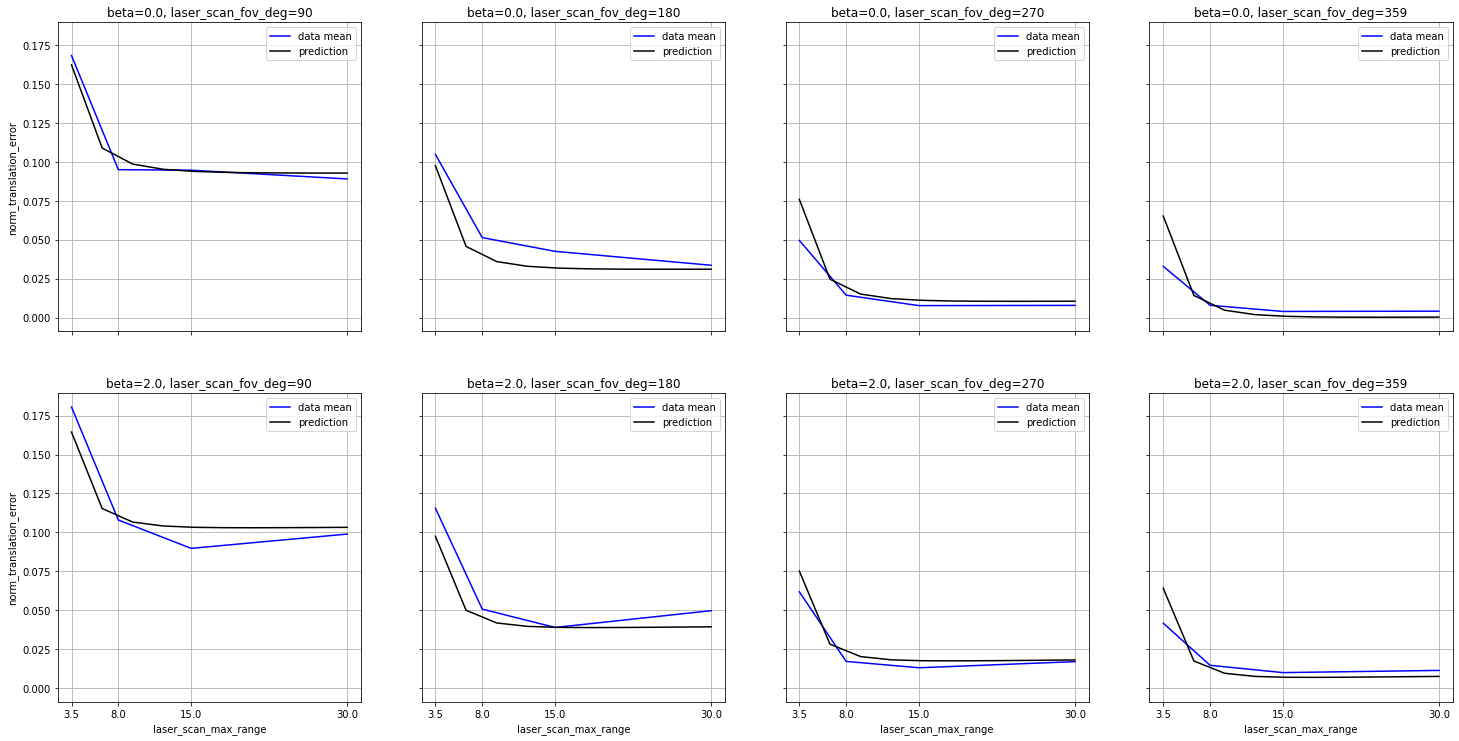

## Slice along laser_scan_fov_deg

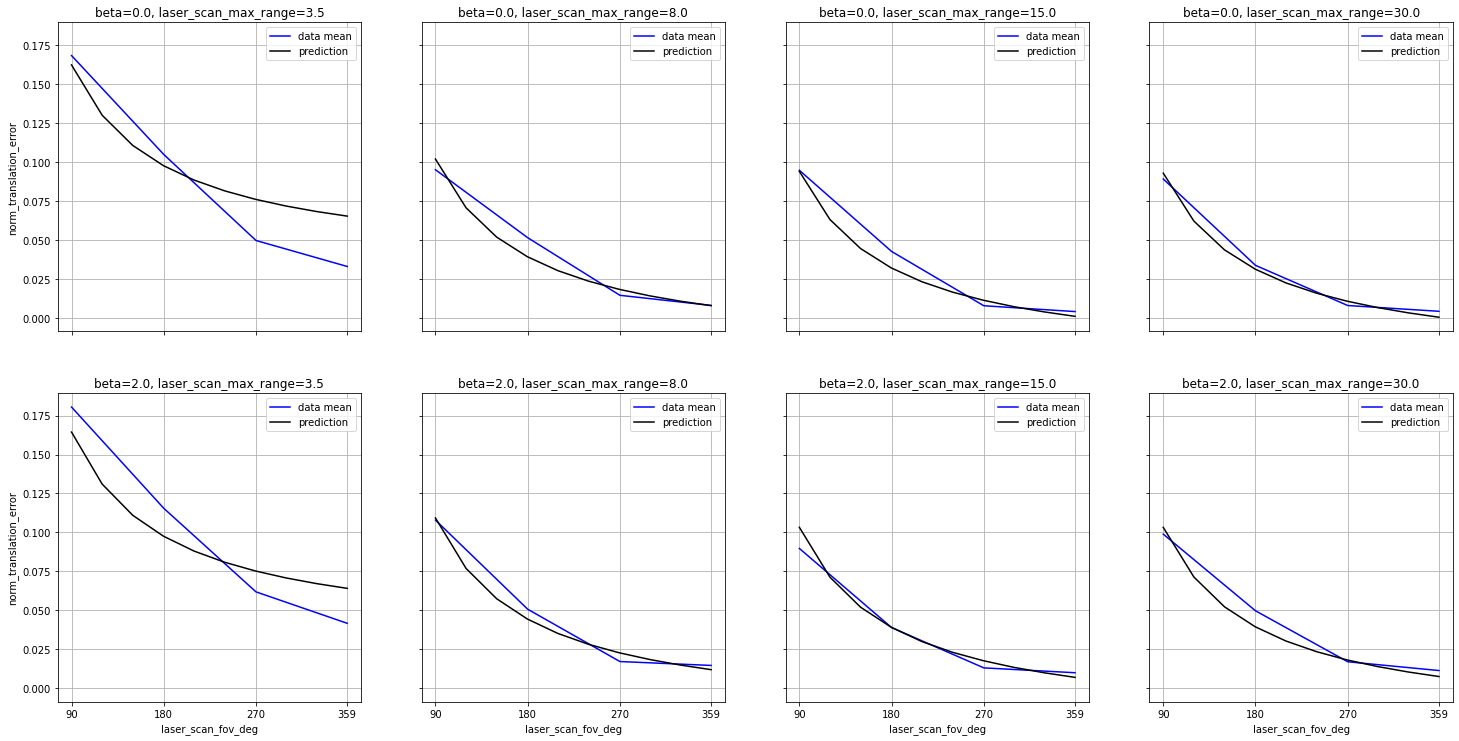

## Slice along beta

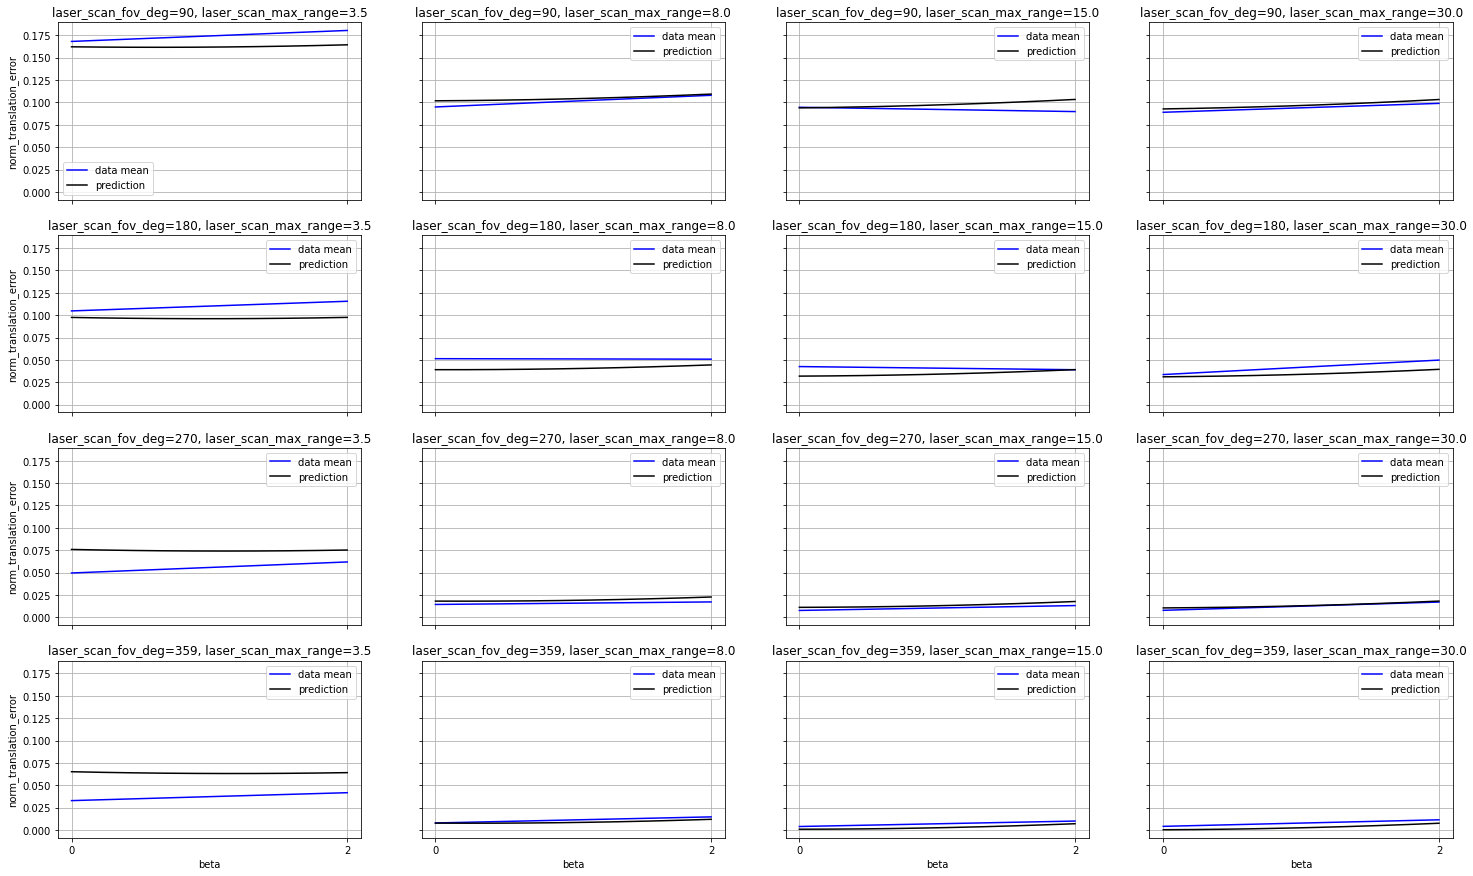

In [6]:
num_polynomial_features = 2

slam_node = "slam_toolbox"
output_metric = df.norm_translation_error

df_by_params = df[df.slam_node == slam_node].groupby(robot_parameters).mean()

X = np.array(list(df_by_params[output_metric.name].index))
X[:, 0] = 1/X[:, 0]
X[:, 1] = 1/X[:, 1]

y = df_by_params[output_metric.name].values

model_gm = make_pipeline(PolynomialFeatures(num_polynomial_features), HuberRegressor())
model_gm.fit(X, y);

params = [
    [df.beta, df.laser_scan_fov_deg, df.laser_scan_max_range],
    [df.beta, df.laser_scan_max_range, df.laser_scan_fov_deg],
    [df.laser_scan_fov_deg, df.laser_scan_max_range, df.beta],
]

for param_1, param_2, param_3 in params:
    printmd(f"## Slice along {param_3.name}")
    
    param_1_values = sorted(list(param_1.unique()))
    param_2_values = sorted(list(param_2.unique()))
    param_3_values = sorted(list(param_3.unique()))
    
    fig, axs = plt.subplots(len(param_1_values), len(param_2_values))
    fig.set_size_inches([25, min(15, 25*len(param_1_values)/len(param_2_values))])
    for i, param_1_value in enumerate(param_1_values):
        for j, param_2_value in enumerate(param_2_values):

            df_gm_params = df[
                (df.slam_node == slam_node) &
                (param_1 == param_1_value) &
                (param_2 == param_2_value)
            ]

            df_gm_params_mean = df_gm_params.groupby(df_gm_params[param_3.name]).mean()
            x_mean = df_gm_params_mean.index
            y_mean = df_gm_params_mean[output_metric.name]
            axs[i, j].plot(x_mean, y_mean, label="data mean", color=slam_node_colors[slam_node])

            x_plot = np.linspace(min(param_3_values), max(param_3_values), 10)
            d = dict()
            d[param_1.name] = param_1_value
            d[param_2.name] = param_2_value
            x_pred = np.array([[
                1/(d['laser_scan_max_range'] if 'laser_scan_max_range' in d else param_3_value),
                1/(d['laser_scan_fov_deg'] if 'laser_scan_fov_deg' in d else param_3_value),
                d['beta'] if 'beta' in d else param_3_value
            ] for param_3_value in x_plot])
            y_pred = model_gm.predict(x_pred)
            axs[i, j].plot(x_plot, y_pred, color="black", label="prediction")

            axs[i, j].set_title(f"{param_1.name}={param_1_value}, {param_2.name}={param_2_value}")
            axs[i, j].set_xlabel(param_3.name)
            axs[i, j].set_ylabel(output_metric.name)
            axs[i, j].sharex(axs[0, 0])
            axs[i, j].sharey(axs[0, 0])
            axs[i, j].grid(True)
            axs[i, j].label_outer()
            axs[i, j].legend()
    plt.xticks(x_mean)
    plt.show()
